In [1]:
# Import necessary libraries
import polars as pl
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
%config InteractiveShell.ast_node_interactivity = 'last_expr_or_assign'

In [3]:
#Load mega_df from parquet
df = pl.read_parquet('/data/scratch/shaivilp/two_l_mega_df.parquet')

routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,nextStopID,nextStopETA,nextPatternStopID,h,lastStopID,lastPatternStopID,scheduleNumber,inService,onSchedule,trainID,receiveTime,aID,captureTime,direction,seq,lastStopExtID,nextStopExtID,nextStopPctProg,atStop,__index_level_0__,nextStopName,lastStopName,stopChanged,nextToLast,timeDiff,routeID_right,patternID_right,…,lng_right,load_right,capacity_right,eLoad_right,blockID_right,nextStopID_right,nextStopETA_right,nextPatternStopID_right,h_right,lastStopID_right,lastPatternStopID_right,scheduleNumber_right,inService_right,onSchedule_right,trainID_right,aID_right,captureTime_right,direction_right,seq_right,lastStopExtID_right,nextStopExtID_right,nextStopPctProg_right,atStop_right,__index_level_0___right,nextStopName_right,lastStopName_right,stopChanged_right,nextToLast_right,timeDiff_right,receiveTime_right,nextStopID_actual,nextStopName_actual,eta,hour_of_day,minute_of_hour,day_of_week,eta_seconds
str,i64,str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,datetime[ns],str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns],str,i64,…,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,bool,f64,i64,str,datetime[ns],cat,i64,i64,i64,f64,bool,i64,str,str,bool,bool,duration[ns],datetime[ns],i64,str,duration[ns],i8,i8,i8,i64
"""2L""",3,"""Old_1501""",329,41.93639,-88.7736,0,0,33,0,465,1145,10482,271,433,10481,"""19:00:00-2""",true,-2.0,11414,2024-09-01 00:04:41,"""354676050595540""",2024-09-01 00:04:48,"""Outbound""",4,433,465,0.0,true,538,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,40s,"""2L""",3,…,-88.7754,0,0,33,0,466,1146,10483,0,465,10482,"""19:00:00-2""",true,-2.0,11414,"""354676050595540""",2024-09-01 00:05:33,"""Outbound""",5,465,466,0.0,true,619,"""Grant North""","""Stadium Dr. at New Hall""",true,true,1m,2024-09-01 00:05:21,465,"""Stadium Dr. at New Hall""",40s,0,4,7,40
"""2L""",3,"""1103""",330,41.93639,-88.77435,0,0,0,0,465,1175,10482,270,433,10481,"""19:30:00-2""",true,-2.0,11415,2024-09-01 00:34:35,"""35467605044c796""",2024-09-01 00:34:47,"""Outbound""",4,433,465,0.0,true,3745,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,41s,"""2L""",3,…,-88.7754,0,0,0,0,466,1176,10483,0,465,10482,"""19:30:00-2""",true,-2.0,11415,"""35467605044c796""",2024-09-01 00:35:18,"""Outbound""",5,465,466,0.0,true,3799,"""Grant North""","""Stadium Dr. at New Hall""",true,true,50s,2024-09-01 00:35:16,465,"""Stadium Dr. at New Hall""",41s,0,34,7,41
"""2L""",3,"""1103""",331,41.93638,-88.77397,0,0,8,0,465,1204,10482,270,433,10481,"""20:00:00-2""",true,-1.0,11416,2024-09-01 01:03:34,"""35467605044c796""",2024-09-01 01:03:47,"""Outbound""",4,433,465,0.0,true,6850,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,51s,"""2L""",3,…,-88.7754,0,0,8,0,466,1205,10483,0,465,10482,"""20:00:00-2""",true,-1.0,11416,"""35467605044c796""",2024-09-01 01:04:32,"""Outbound""",5,465,466,0.0,true,6931,"""Grant North""","""Stadium Dr. at New Hall""",true,true,1m,2024-09-01 01:04:25,465,"""Stadium Dr. at New Hall""",51s,1,3,7,51
"""2L""",3,"""1103""",332,41.93639,-88.77435,0,0,18,0,465,1234,10482,270,433,10481,"""20:30:00-2""",true,-1.0,11417,2024-09-01 01:33:46,"""35467605044c796""",2024-09-01 01:34:02,"""Outbound""",4,433,465,0.0,true,10090,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,51s,"""2L""",3,…,-88.77539,0,0,18,0,466,1235,10483,0,465,10482,"""20:30:00-2""",true,-1.0,11417,"""35467605044c796""",2024-09-01 01:34:47,"""Outbound""",5,465,466,8.476742,true,10171,"""Grant North""","""Stadium Dr. at New Hall""",true,true,50s,2024-09-01 01:34:37,465,"""Stadium Dr. at New Hall""",51s,1,33,7,51
"""2L""",3,"""1103""",338,41.9364,-88.77528,0,0,31,0,465,1265,10482,270,433,10481,"""21:00:00-2""",true,-2.0,11423,2024-09-01 02:04:05,"""35467605044c796""",2024-09-01 02:04:16,"""Outbound""",4,433,465,29.23959,true,13330,"""Stadium Dr. at New Hall""","""Lincoln Hall""",true,true,30s,"""2L""",3,…,-88.77539,0,0,31,0,466,1265

In [4]:
pdf = df.to_pandas()

,routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,...,nextToLast_right,timeDiff_right,receiveTime_right,nextStopID_actual,nextStopName_actual,eta,hour_of_day,minute_of_hour,day_of_week,eta_seconds
0,2L,3,Old_1501,329.0,41.93639,-88.77360,0,0,33,0,...,True,0 days 00:01:00,2024-09-01 00:05:21,465,Stadium Dr. at New Hall,0 days 00:00:40,0,4,7,40
1,2L,3,1103,330.0,41.93639,-88.77435,0,0,0,0,...,True,0 days 00:00:50,2024-09-01 00:35:16,465,Stadium Dr. at New Hall,0 days 00:00:41,0,34,7,41
2,2L,3,1103,331.0,41.93638,-88.77397,0,0,8,0,...,True,0 days 00:01:00,2024-09-01 01:04:25,465,Stadium Dr. at New Hall,0 days 00:00:51,1,3,7,51
3,2L,3,1103,332.0,41.93639,-88.77435,0,0,18,0,...,True,0 days 00:00:50,2024-09-01 01:34:37,465,Stadium Dr. at New Hall,0 days 00:00:51,1,33,7,51
4,2L,3,1103,338.0,41.93640,-88.77528,0,0,31,0,...,True,0 days 00:00:50,2024-09-01 02:04:35,465,Stadium Dr. at New Hall,0 days 00:00:30,2,4,7,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161794,2L,3,701,NaN,41.93556,-88.77041,0,0,0,0,...,True,0 days 00:01:00,2024-09-30 22:31:49,468,Stevenson South,0 days 00:06:32,22,25,1,392
161795,2L,3,1002,NaN,41.93523,-88.77054,0,0,179,0,...,True,0 days 00:00:50,2024-09-30 22:44:17,468,Stevenson South,0 days 00:08:51,22,35,1,531
161796,2L,3,701,NaN,41.93523,-88.77054,0,0,0,0,...,True,0 days 00:00:30,2024-09-30 23:00:47,468,Stevenson South,0 days 00:07:31,22,53,1,451
161797,2L,3,1002,NaN,41.93541,-88.77046,0,0,215,0,...,True,0 days 00:01:10,2024-09-30 23:11:38,468,Stevenson South,0 days 00:07:21,23,4,1,441


In [5]:
# Check for missing values before dropping columns
print(pdf.isna().sum())

routeID                0
patternID              0
equipmentID            0
tripID            101861
lat                    0
                   ...  
eta                    0
hour_of_day            0
minute_of_hour         0
day_of_week            0
eta_seconds            0
Length: 76, dtype: int64


In [6]:
pdf = pdf.dropna()

,routeID,patternID,equipmentID,tripID,lat,lng,load,capacity,eLoad,blockID,...,nextToLast_right,timeDiff_right,receiveTime_right,nextStopID_actual,nextStopName_actual,eta,hour_of_day,minute_of_hour,day_of_week,eta_seconds
0,2L,3,Old_1501,329.0,41.93639,-88.77360,0,0,33,0,...,True,0 days 00:01:00,2024-09-01 00:05:21,465,Stadium Dr. at New Hall,0 days 00:00:40,0,4,7,40
1,2L,3,1103,330.0,41.93639,-88.77435,0,0,0,0,...,True,0 days 00:00:50,2024-09-01 00:35:16,465,Stadium Dr. at New Hall,0 days 00:00:41,0,34,7,41
2,2L,3,1103,331.0,41.93638,-88.77397,0,0,8,0,...,True,0 days 00:01:00,2024-09-01 01:04:25,465,Stadium Dr. at New Hall,0 days 00:00:51,1,3,7,51
3,2L,3,1103,332.0,41.93639,-88.77435,0,0,18,0,...,True,0 days 00:00:50,2024-09-01 01:34:37,465,Stadium Dr. at New Hall,0 days 00:00:51,1,33,7,51
4,2L,3,1103,338.0,41.93640,-88.77528,0,0,31,0,...,True,0 days 00:00:50,2024-09-01 02:04:35,465,Stadium Dr. at New Hall,0 days 00:00:30,2,4,7,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161768,2L,3,1002,6.0,41.93507,-88.77061,0,0,6,0,...,True,0 days 00:00:50,2024-09-30 18:39:08,468,Stevenson South,0 days 00:07:11,18,31,1,431
161772,2L,3,1002,7.0,41.93523,-88.77054,0,0,7,0,...,True,0 days 00:01:00,2024-09-30 19:09:41,468,Stevenson South,0 days 00:07:31,19,2,1,451
161786,2L,3,501,11.0,41.93523,-88.77054,0,0,174,0,...,True,0 days 00:01:01,2024-09-30 21:03:53,468,Stevenson South,0 days 00:06:40,20,57,1,400
161787,2L,3,1002,11.0,41.93556,-88.77041,0,0,91,0,...,True,0 days 00:01:10,2024-09-30 21:10:37,468,Stevenson South,0 days 00:07:41,21,2,1,461


In [7]:
# Check for missing values after dropping columns
print(pdf.isna().sum())

routeID           0
patternID         0
equipmentID       0
tripID            0
lat               0
                 ..
eta               0
hour_of_day       0
minute_of_hour    0
day_of_week       0
eta_seconds       0
Length: 76, dtype: int64


In [8]:
# Define features and target
X = pdf.drop('eta_seconds', axis=1)
y = pdf['eta_seconds']

0          40
1          41
2          51
3          51
4          30
         ... 
161768    431
161772    451
161786    400
161787    461
161790    511
Name: eta_seconds, Length: 58178, dtype: int64

In [9]:
categorical_features = ['routeID', 'lastStopID', 'nextStopID_actual']
numerical_features = ['hour_of_day', 'minute_of_hour', 'day_of_week'] 

['hour_of_day', 'minute_of_hour', 'day_of_week']

In [10]:
# Create preprocessing pipeline
# OneHotEncoder for routeID, StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['hour_of_day', 'minute_of_hour',
                                  'day_of_week']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['routeID', 'lastStopID',
                                  'nextStopID_actual'])])

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Create a pipeline with preprocessing and SGD regressor
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour_of_day',
                                                   'minute_of_hour',
                                                   'day_of_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['routeID', 'lastStopID',
                                                   'nextStopID_actual'])])),
                ('regressor', SGDRegressor(random_state=42))])

In [13]:
# Define hyperparameters to tune
param_grid = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'regressor__loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'regressor__penalty': ['l2', 'l1', 'elasticnet'],
    'regressor__learning_rate': ['constant', 'optimal', 'adaptive']
}

{'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
 'regressor__loss': ['squared_error', 'huber', 'epsilon_insensitive'],
 'regressor__penalty': ['l2', 'l1', 'elasticnet'],
 'regressor__learning_rate': ['constant', 'optimal', 'adaptive']}

In [ ]:
# Use GridSearchCV to find the best hyperparameters
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    sgd_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
)

Starting hyperparameter tuning...


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['hour_of_day',
                                                                          'minute_of_hour',
                                                                          'day_of_week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['routeID',
                                                                          'lastStopID',
                                                                          'nextStopID_actual'])])),
                                       ('regressor',
                                        SGDRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'regressor__learning_rate': ['constant', 'optimal',
                                                      'adaptive'],
                         'regressor__loss': ['squared_error', 'huber',
                                             'epsilon_insensitive'],
                         'regressor__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error', verbose=1)

In [15]:
# Train the model
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


/home/shaivilp/busmodel/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/shaivilp/busmodel/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/shaivilp/busmodel/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/shaivilp/busmodel/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['hour_of_day',
                                                                          'minute_of_hour',
                                                                          'day_of_week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['routeID',
                                                                          'lastStopID',
                                                                          'nextStopID_actual'])])),
                                       ('regressor',
                                        SGDRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'regressor__learning_rate': ['constant', 'optimal',
                                                      'adaptive'],
                         'regressor__loss': ['squared_error', 'huber',
                                             'epsilon_insensitive'],
                         'regressor__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
# Get the best model
best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")



Best parameters: {'regressor__alpha': 0.0001, 'regressor__learning_rate': 'adaptive', 'regressor__loss': 'squared_error', 'regressor__penalty': 'l1'}


In [17]:
# Export the best model as training takes a long time
print("Exporting best model to best_model.pkl...")
joblib.dump(best_model, 'best_model.pkl')

Exporting best model to best_model.pkl...


['best_model.pkl']

In [18]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

array([249.16700573, 642.747079  , 188.07537322, ...,  12.05378708,
       202.83870821, 653.04453907], shape=(11636,))

In [19]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Absolute Error: {mae:.2f} seconds")
print(f"Root Mean Squared Error: {rmse:.2f} seconds")
print(f"R² Score: {r2:.4f}")


Model Performance:
Mean Absolute Error: 109.13 seconds
Root Mean Squared Error: 135.56 seconds
R² Score: 0.6036


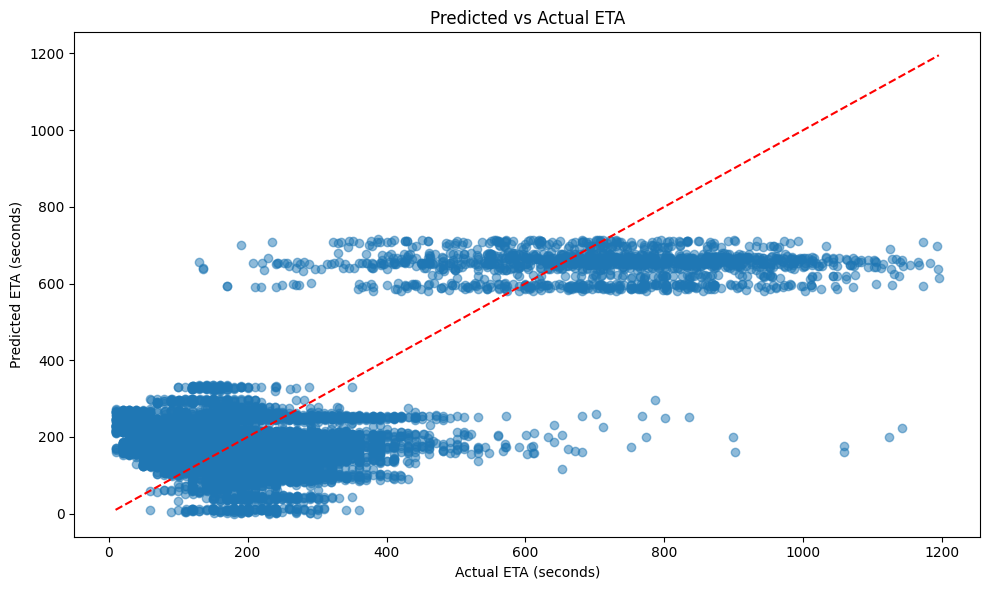

In [20]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ETA (seconds)')
plt.ylabel('Predicted ETA (seconds)')
plt.title('Predicted vs Actual ETA')
plt.tight_layout()
plt.show()

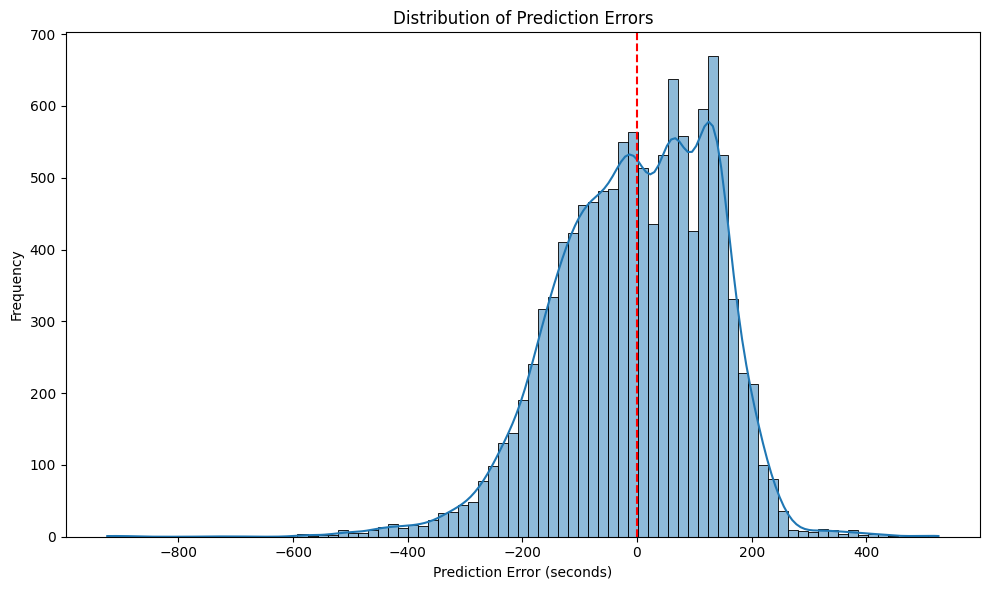

In [21]:
# Visualize error distribution
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [22]:
# Example: Make predictions for new data
new_observation = pd.DataFrame({
    "routeID": ["2L"],
    "lastStopID": [820],
    "nextStopID_actual": [433],
    "hour_of_day": [17],
    "minute_of_hour": [30],
    "day_of_week": [4]
})

# Make prediction
loaded_model = joblib.load('best_model.pkl')
eta_prediction = loaded_model.predict(new_observation)
print(f"\nPredicted ETA for new observation: {eta_prediction[0]:.2f} seconds")


Predicted ETA for new observation: 295.29 seconds


In [23]:
# Feature importance analysis (only for numerical features)
feature_names = numerical_features + [f"routeID_{cat}" for cat in best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['routeID'])]
feature_importances = np.abs(best_model.named_steps['regressor'].coef_)


ValueError: input_features is not equal to feature_names_in_

In [ ]:
# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
2,hour_of_day,23385.541805
1,nextStopID_actual,9421.435332
3,minute_of_hour,3292.834692
4,day_of_week,1046.918635
0,lastStopID,547.856655
5,routeID_routeID_2L,21.669116


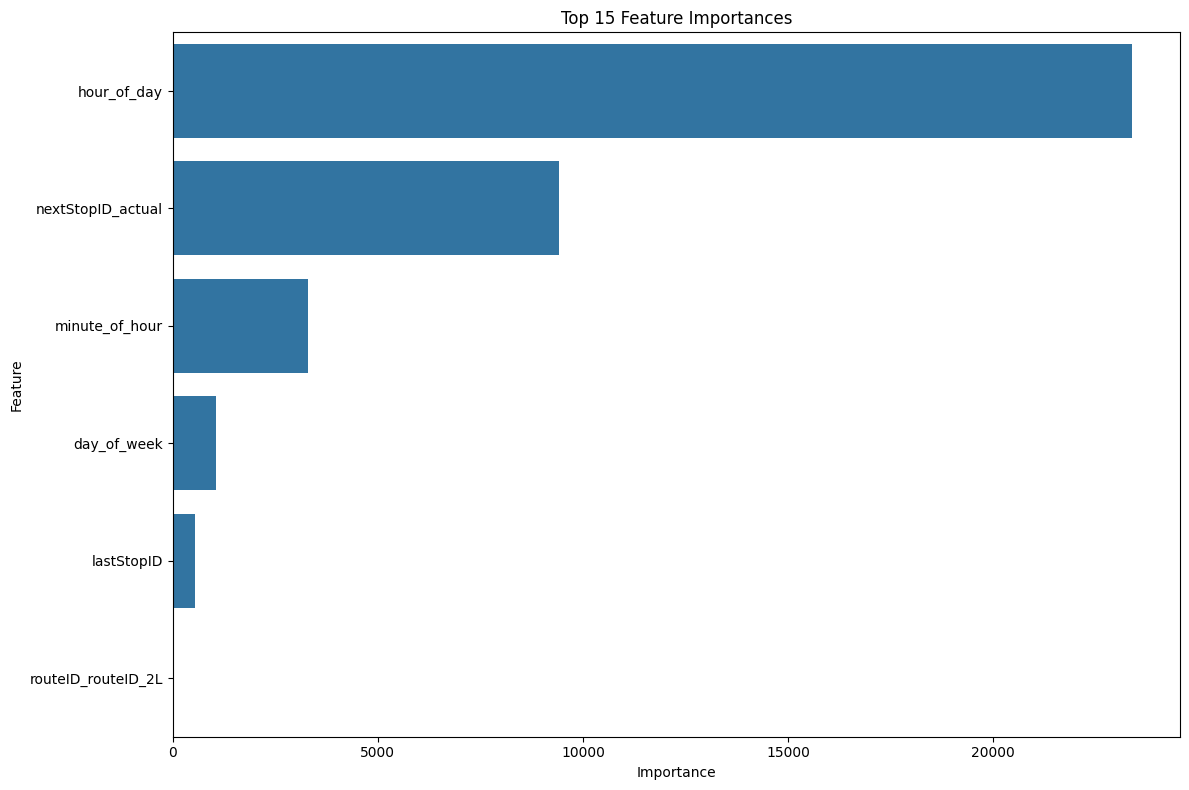

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()